Dissertation - Biomedical Engineering

2020/2021

Ana Catarina Monteiro Magalhães

Sensors - Zebrafish vital signs and water temperature data analysis

File: Data_analyze.ipynb

Date: 06-09-2021

Description: This notebook contains the analysis of the data obtained by the heartbeat sensors and the thermistor.  


### Imports

In [2]:
import scipy
import serial
import time
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
import scipy.signal as signal
from scipy.signal import find_peaks
from scipy import fftpack
from scipy.optimize import curve_fit
#from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt
from scipy.stats import norm
import statistics

Information of the zebrafish and the section of the data

In [25]:
trial = 3
fish_number = 2
bn = 210
fn = 235
# time at which the data started to be saved
init = 10.92

In [26]:
if trial == 2:
    # Sampling period
    ta = 0.05
    # Cutoff frequency
    Wn = [0.01, 0.4] 
if trial == 3:
    # Sampling period
    ta = 0.01 
    # Cutoff frequency
    Wn = [0.002, 0.08]   
print(ta)
print(Wn)

0.01
[0.002, 0.08]


In [45]:
# Files from trial 2
A2_1 = "20210624-143847-peixe1.csv"
A2_2 = "20210624-145602-peixe2.csv"
A2_3 = "20210624-151249-peixe3.csv"
A2_4 = "20210624-155357-peixe4.csv"
A2_5 = "20210624-153033-peixe5.csv"

# Files from trial 3
A3_1 = "20210714-150307_peixe1.csv"
A3_2 = "20210714-152517_peixe2.csv"
A3_3 = "20210714-160833_peixe3.2.csv"
A3_4 = "20210714-162911_peixe4.csv"

Read .csv data

In [28]:
data=pd.read_csv(A3_2)
data.columns = ['Tempo','Amplitude', 'Temperatura']
print(data)

begin= int(bn/0.01)- int(init/0.01)
finish = int(fn/0.01)- int(init/0.01)

          Tempo  Amplitude  Temperatura
0         11.03       6393        24.38
1         11.04       6921        24.38
2         11.05       6640        24.28
3         11.06       6458        24.28
4         11.07       6499        24.38
...         ...        ...          ...
139583  1407.92      12265        24.18
139584  1407.93      11210        24.08
139585  1407.94       8622        24.18
139586  1407.95       3805        24.28
139587  1407.96          0        24.18

[139588 rows x 3 columns]


Data plot

<IPython.core.display.Javascript object>


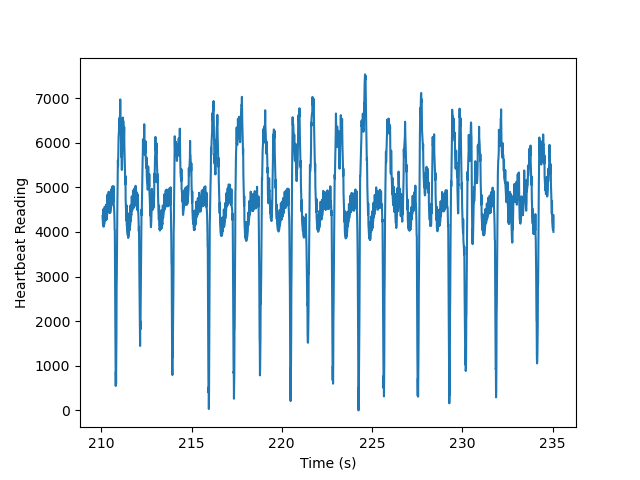

In [30]:
plt.plot(data['Tempo'][begin:finish],data['Amplitude'][begin:finish])
plt.xlabel('Time (s)')
plt.ylabel('Heartbeat Reading')
plt.show()

## Heartbeat sensors readings

## Data filtering

In [31]:
#Design the Butterworth filter
# Filter order
N  = 2      

# Application of the filter to the data
B, A = signal.butter(N, Wn,'bandpass', output='ba')
smooth_data = signal.filtfilt(B,A, data['Amplitude'][begin:finish])

<IPython.core.display.Javascript object>


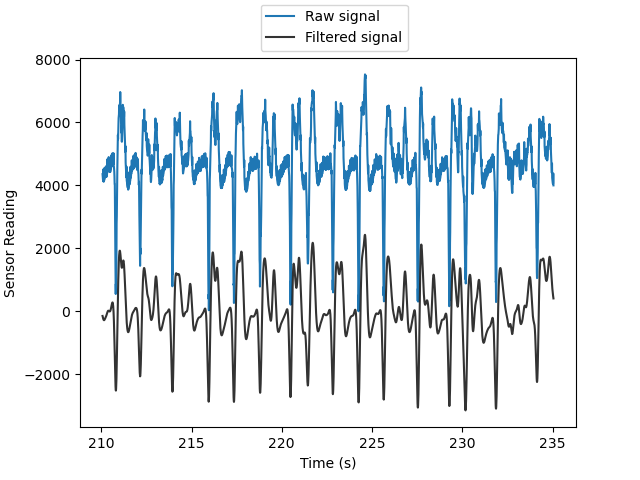

In [32]:
# Plot Raw data vs Filtered data
plt.plot(data['Tempo'][begin:finish],data['Amplitude'][begin:finish],'-', color='C0', label='Raw signal', alpha = 1)
plt.plot(data['Tempo'][begin:finish],smooth_data,'k-', alpha = 0.8, label='Filtered signal')
plt.legend(['Raw signal','Filtered signal'], bbox_to_anchor = (0.35, 1))
plt.xlabel('Time (s)')
plt.ylabel('Sensor Reading')
plt.show()

## FFT

In [33]:
D = data['Amplitude'][begin:finish].to_numpy()
# FFT of the raw data
Y_raw =abs(np.fft.fft(D))
# FFT of the filtered data
Y_smooth = abs(np.fft.fft(smooth_data))

# Sampling frequency
Fa=1/ta

N=data['Tempo'][begin:finish].size
x_fft=np.linspace(0.0,1.0/(2.0*ta),N//2)
f_raw = 2.0/N * abs(Y_raw[:N//2]) 
f_smooth = 2.0/N * abs(Y_smooth[:N//2])
n=len(x_fft)

<IPython.core.display.Javascript object>


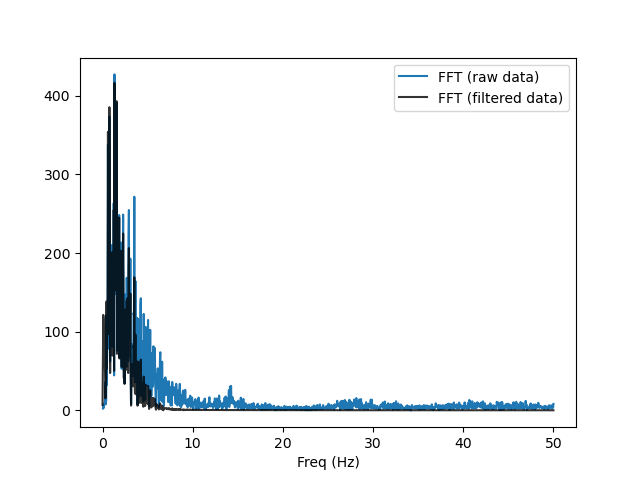

In [34]:
# Plot Raw data FFT vs Filtered data FFT 
plt.plot(x_fft[1:],f_raw[1:], color='C0', label = 'FFT (raw data)', alpha = 1)
plt.plot(x_fft[:],f_smooth[:],'k', label = 'FFT (filtered data)', alpha = 0.8)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

## Gaussian Curve Adjustment to the FFT 

In [35]:
#Gaussian function
def gaussian(x, a, mean, sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

# Function for a sum of two gaussians
def gaussian_sum2(x, a, mean, sigma, a1, mean1, sigma1):
    return (a*np.exp(-(x-mean)**2/(2*sigma**2))) + (a1*np.exp(-(x-mean1)**2/(2*sigma1**2)))

The initial values of the gaussian curve vary depending on the data. The values for different data sets will then be presented.

### Trial 2
- Zebrafish 2.2
    - (bn = 260, fn = 310) p0 = [30, 1.5, 0.5, 10, 2.5, 0.5]
    - (bn = 454, fn = 472) p0 = [40, 2, 0.5]
- Zebrafish 2.4
    - (bn = 205, fn = 273) p0 = [10, 1.5, 0.5, 2, 2, 0.5]
    - (bn = 290, fn = 326) p0 = [10, 1.5, 0.5, 5, 2, 0.5]
- Zebrafish 2.5
    - (bn = 564, fn = 630) p0 = [100, 2.5, 0.5]

### Trial 3
- Zebrafish 3.2
    - (bn = 210, fn = 235) p0 = [300, 1.5, 0.5]
- Zebrafish 3.4
    - (bn = 300, fn = 330) p0 = [500, 1.5, 0.5]

In [36]:
# Best values for a, mean and sigma for the best gaussian curve fit
best_vals, cov_vals = curve_fit(f=gaussian, xdata=x_fft[2:], ydata = f_smooth[2:], p0=[300, 1.5,0.5])
print(best_vals)

[172.21873555   1.48420107   1.27570807]


Gaussiana 1: 1.4842010659577414


<IPython.core.display.Javascript object>


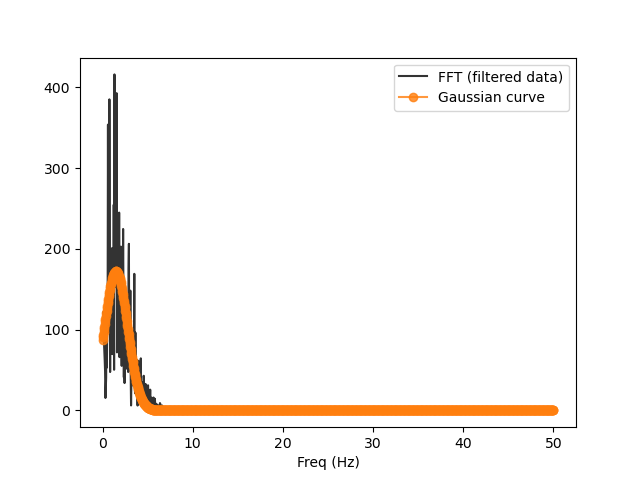

In [37]:
y_fft1 = gaussian(x_fft,best_vals[0],best_vals[1],best_vals[2])
print("Gaussiana 1: {}".format(best_vals[1]))
# y_fft2 = gaussian(x_fft,best_vals[3],best_vals[4],best_vals[5])
# print("Gaussiana 2: {}".format(best_vals[4]))


plt.plot(x_fft[2:],f_smooth[2:],'k',label='FFT (filtered data)',  alpha = 0.8)
plt.plot(x_fft,gaussian(x_fft, *best_vals),'o-',color = 'C1',label='Gaussian curve', alpha = 0.8)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

## Find_peaks

The find_peaks parameters vary depending on the data. The values for different data sets will then be presented.

### Trial 2
- Zebrafish 2.2
    - (bn = 260, fn = 310) height = 0.25, distance = 11, threshold = 0.000001
    - (bn = 454, fn = 472) height = 0.4, distance = 7, threshold = 0.00001
- Zebrafish 2.4
    - (bn = 205, fn = 273) height = 0.15, distance = 7, threshold = 0.00001
    - (bn = 290, fn = 326) height = 0.25, distance = 10, threshold = 0.00001
- Zebrafish 2.5
    - (bn = 564, fn = 630) height = 0.15, distance = 5, threshold = 0.00001

    
### Trial 3
- Zebrafish 3.2
    - (bn = 210, fn = 235) height = -0.5, distance = 30, threshold = 0.00001
- Zebrafish 3.4
    - (bn = 624, fn = 631) height = 0, distance = 35, threshold = 0.000001


heart_peaks [55, 96, 185, 230, 296, 368, 408, 485, 568, 611, 707, 769, 854, 898, 950, 1088, 1120, 1164, 1228, 1258, 1323, 1400, 1454, 1539, 1582, 1643, 1677, 1729, 1767, 1798, 1835, 1903, 1943, 1982, 2036, 2086, 2161, 2205, 2260, 2303, 2368, 2442, 2478]

operculum peaks []


<IPython.core.display.Javascript object>


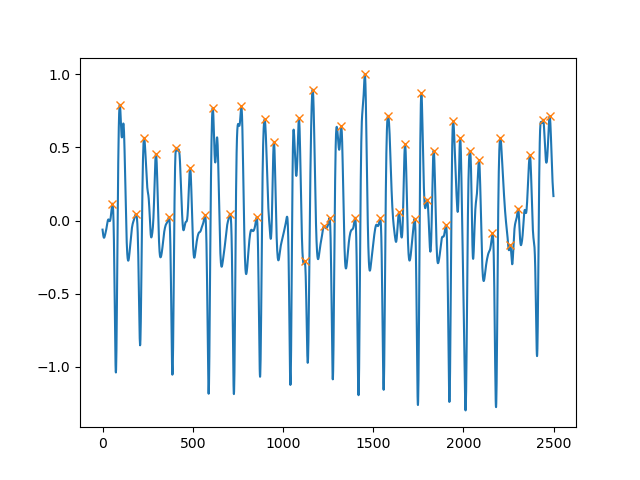

In [43]:
smooth_data = smooth_data/max(smooth_data)

# Selection of the peaks correspondent to the opercular movement
peaks_op, _ = find_peaks(smooth_data, height =1.1, distance = 35, threshold = 0.0000000001) #retorna os indices dos picos 

# Selection of all peaks present in the signal
peaks_all, _ = find_peaks(smooth_data, height =-0.5, distance = 30, threshold = 0.00001)
peak = peaks_all.tolist()


d = len(peak)-len(peaks_op)

# Removal of the operculum peaks - Results in the peaks correspondents to the heart
for n in range(len(peaks_op)):
    for m in range(d): 
        if peaks_op[n] == peak[m]:
            peak.remove(peak[m])
          
print("\nheart_peaks {}\n".format(peak))
print("operculum peaks {}". format(peaks_op))

plt.plot(smooth_data)
plt.plot(peak, smooth_data[peak], "x")
plt.show()

## Heart Rate calculation

In [41]:
heart_beat = []

for n in range(len(peak)-1):
    delta_t = data['Tempo'][peak[n+1]]-data['Tempo'][peak[n]]
    if delta_t < 10:
        f_min = 60/delta_t
        heart_beat.append(f_min)
        
    else:
        print("error")

print('Heart rate: {} bpm'.format(round(np.mean(heart_beat),1)))

Heart rate: 117.3 bpm


## Thermistor Readings

<IPython.core.display.Javascript object>


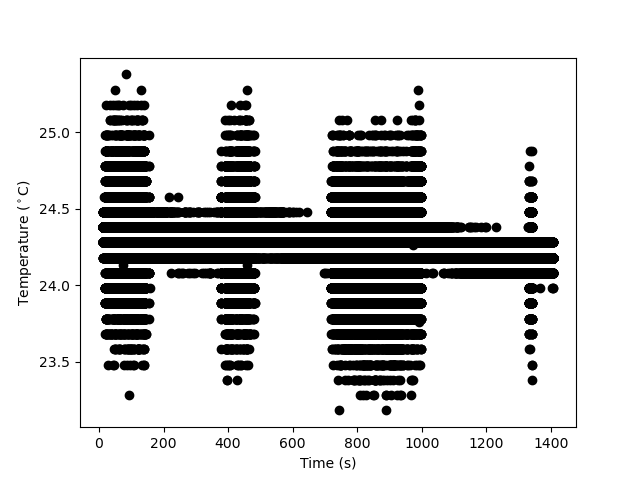

In [44]:
plt.plot(data['Tempo'], data['Temperatura'], 'ko')
plt.xlabel('Time (s)')
plt.ylabel('Temperature ($^\circ$C)')
plt.show()